# Graph Construction

In this notebook, we are exploring the standard construction of the Graph using a GNN + GSL model.

In [1]:
from config import CONFIG
from model.metro_model import MetroModel
from data.metro_dataset import MetroDataset

import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
import os
from pathlib import Path
import networkx as nx
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

torch.manual_seed(0)

c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\momepy\coins.py:15: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
imp

In [2]:
dataset = MetroDataset(CONFIG.lines, init_nb=20)
num_nodes = dataset.cg.num_nodes()
dataset.cg.altair_graph(dataset.cg.graph, 10)

c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\momepy\utils.py:430: UserWarning: Approach is not set. Defaulting to 'primal'.
  warnings.warn("Approach is not set. Defaulting to 'primal'.")


alt.LayerChart(...)

## Model

In [3]:
model = MetroModel(embedding_size=8, num_nodes=num_nodes, neighbor_nb=1, input_size=1, gsl_mode="matrix")

## Training

In [4]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8)
checkpoint_callback = ModelCheckpoint(dirpath="checkpoints/", save_top_k=1000 ,monitor="loss") # , every_n_train_steps=100, 
trainer = Trainer(max_epochs=400, callbacks=[checkpoint_callback])
trainer.fit(model, train_loader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name         

Epoch 399: 100%|██████████| 248/248 [00:01<00:00, 174.28it/s, loss=1.36e-05, v_num=12]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 248/248 [00:01<00:00, 170.92it/s, loss=1.36e-05, v_num=12]


## Visualization of results

In [5]:
A_reference = dataset.cg.adjacency_matrix().reshape(-1)

In [6]:
def load_model(path):
    checkpoint = torch.load(path)
    model = MetroModel(embedding_size=8, num_nodes=num_nodes, neighbor_nb=1, input_size=1, gsl_mode="matrix")
    model.load_state_dict(checkpoint['state_dict'])
    return model

def viz(checkpoint, threshold = 0):
    model = load_model(checkpoint)

    A = model.graph_matrix_learning().detach().numpy()
    A = np.array(A) > threshold

    learned_graph = nx.from_numpy_array(A, nx.DiGraph)
    return dataset.cg.altair_graph(learned_graph, 10)

def precision_recall(checkpoint, threshold = 0):
    model = load_model(checkpoint)

    A = model.graph_matrix_learning().detach().numpy()
    A = np.array(A).reshape(-1)
    A = A > threshold
    precision = precision_score(A_reference > 0, A)  
    recall = recall_score(A_reference > 0, A) 
    return precision, recall

def graph_edit_distance(checkpoint):
    model = load_model(checkpoint)
    A = model.graph_matrix_learning().detach().numpy()
    A = np.array(A) 
    learned_graph = nx.from_numpy_array(A, nx.DiGraph)
    return nx.graph_edit_distance(dataset.cg.graph, learned_graph)


recalls = {}
precisions = {}
for path in sorted(os.listdir('checkpoints')):
    checkpoint = Path('checkpoints') / path
    number = path.split("=")[1][:-5]
    precision, recall = precision_recall(checkpoint, 0.075)
    precisions[int(number)] = precision
    recalls[int(number)] = recall

c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages

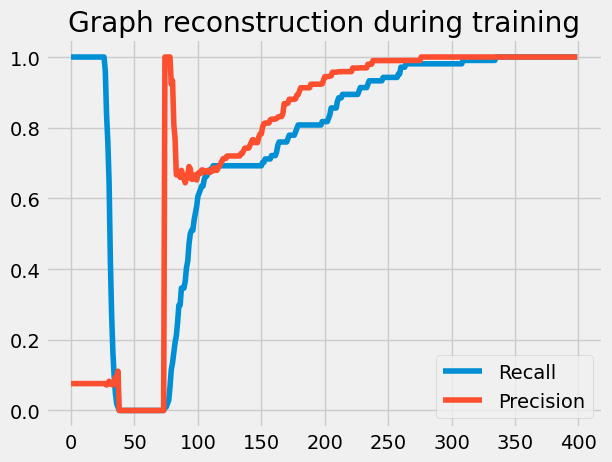

In [11]:
plt.style.use('fivethirtyeight')
plt.plot(sorted(recalls.keys()), [x for _, x in sorted(zip(recalls.keys(), recalls.values()))], label="Recall")
plt.plot(sorted(precisions.keys()), [x for _, x in sorted(zip(precisions.keys(), precisions.values()))], label="Precision")
plt.title('Graph reconstruction during training')
plt.legend()
plt.savefig('reconstruction-steps.png', dpi=300)
plt.show()

In [8]:
print(precision_recall("checkpoints\epoch=0-step=248.ckpt"))
viz("checkpoints\epoch=0-step=248.ckpt", 0.075)

(0.07596785975164354, 1.0)


c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\momepy\utils.py:430: UserWarning: Approach is not set. Defaulting to 'primal'.
  warnings.warn("Approach is not set. Defaulting to 'primal'.")


alt.LayerChart(...)

In [24]:
viz("checkpoints\epoch=0-step=248.ckpt", 0.075) | viz("checkpoints\epoch=90-step=22568.ckpt", 0.075) | viz("checkpoints\epoch=99-step=24800.ckpt", 0.07)

alt.HConcatChart(...)